# Instalación y Configuración


In [ ]:
# 1. Instalar CatBoost
!pip install catboost -q

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Configurar Kaggle
data = {"username":"josemiguelc1","key":"1a8778db87047d4dc2602b6e2395bf36"}
with open('kaggle.json','w') as f:
    json.dump(data, f)

!chmod 600 kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

# 3. Descargar Datos
print("Descargando datos...")
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -p /content/ --force
!unzip -o -q udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

print("✅ Entorno listo y datos descargados.")

Descargando datos...
  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 811MB/s]
✅ Entorno listo y datos descargados.


#Carga y Preparación

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
TARGET_COL = 'RENDIMIENTO_GLOBAL'
ID_COL = 'ID'

# Unir para aplicar la ingeniería a ambos igual
df_all = pd.concat([df_train.drop(columns=[TARGET_COL]), df_test], axis=0)

print("🧠 Aplicando Ingeniería de Características (Creando nuevas variables)...")

# 1. SCORE DE PRIVILEGIOS (Suma de posesiones)
# Identificamos columnas de "TIENE..." (Internet, Lavadora, Auto, etc.)
cols_tiene = [c for c in df_all.columns if 'TIENE' in c]

# Convertimos 'Si'/'Yes' a 1 y otros a 0 para poder sumar
for col in cols_tiene:
    # Normalizamos texto a minúsculas por si acaso
    df_all[col] = df_all[col].astype(str).str.lower().map({'si': 1, 'yes': 1, 'no': 0}).fillna(0)

# Creamos la nueva columna
df_all['SCORE_PRIVILEGIOS'] = df_all[cols_tiene].sum(axis=1)

# 2. RATIO PERSONAS/CUARTOS (Hacinamiento)
# A veces estas columnas vienen como texto "Uno", "Dos", o números.
# Vamos a intentar extraer números si existen, si no, lo dejamos.
# (Esta parte es avanzada, si da error la saltamos con try/except en tu mente, pero aquí va simple)
# Si tuvieras columnas de '# personas' y '# cuartos', harías: df['Hacinamiento'] = Personas / Cuartos

# 3. INTERACCIÓN ESTRATO vs EDUCACIÓN PADRES
# Combinamos texto para crear perfiles específicos. Ej: "Estrato1_MadrePhD"
# Convertimos a string y rellenamos nulos
estrato = df_all['F_ESTRATOVIVIENDA'].fillna('Desconocido').astype(str)
edu_madre = df_all['F_EDUCACIONMADRE'].fillna('Desconocido').astype(str)
df_all['PERFIL_SOCIOEDUCATIVO'] = estrato + "_" + edu_madre

# --- LIMPIEZA FINAL ---
categorical_cols = df_all.select_dtypes(include=['object']).columns.tolist()
if ID_COL in categorical_cols: categorical_cols.remove(ID_COL)

numeric_cols = df_all.select_dtypes(include=['int64', 'float64']).columns.tolist()
if ID_COL in numeric_cols: numeric_cols.remove(ID_COL)

# Rellenar Nulos (Estrategia CatBoost)
for col in categorical_cols:
    df_all[col] = df_all[col].fillna("Missing").astype(str)

for col in numeric_cols:
    df_all[col] = df_all[col].fillna(-999)

print("✅ Nuevas variables creadas:")
print(df_all[['SCORE_PRIVILEGIOS', 'PERFIL_SOCIOEDUCATIVO']].head())

# Separar
X = df_all.iloc[:len(df_train)].drop(columns=[ID_COL], errors='ignore')
X_test_final = df_all.iloc[len(df_train):].drop(columns=[ID_COL], errors='ignore')
y = df_train[TARGET_COL]
test_ids = df_test[ID_COL] if ID_COL in df_test.columns else df_test.index

🧠 Aplicando Ingeniería de Características (Creando nuevas variables)...
✅ Nuevas variables creadas:
   SCORE_PRIVILEGIOS                         PERFIL_SOCIOEDUCATIVO
0                5.0                           Estrato 3_Postgrado
1                2.0    Estrato 3_Técnica o tecnológica incompleta
2                3.0  Estrato 3_Secundaria (Bachillerato) completa
3                4.0  Estrato 4_Secundaria (Bachillerato) completa
4                5.0                   Estrato 3_Primaria completa


#Entrenamiento con GPU

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print("🚀 Entrenando CatBoost con nuevas características...")

model = CatBoostClassifier(
    iterations=2500,          # Subimos un poco más las iteraciones
    learning_rate=0.04,
    depth=8,                  # Profundidad alta
    l2_leaf_reg=5,            # Un poco más de regularización para no memorizar las nuevas variables

    # GPU
    task_type="GPU",
    devices='0',

    cat_features=categorical_cols, # Importante: PERFIL_SOCIOEDUCATIVO entra aquí
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=500,
    early_stopping_rounds=200
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

print("✅ Entrenamiento completado.")

🚀 Entrenando CatBoost con nuevas características...
0:	learn: 0.3779180	test: 0.3748929	best: 0.3748929 (0)	total: 57.6ms	remaining: 2m 23s
500:	learn: 0.4393731	test: 0.4291312	best: 0.4291312 (500)	total: 18.9s	remaining: 1m 15s
1000:	learn: 0.4523644	test: 0.4310758	best: 0.4316631 (921)	total: 35.7s	remaining: 53.5s
bestTest = 0.4316630566
bestIteration = 921
Shrink model to first 922 iterations.
✅ Entrenamiento completado.


#Evaluación Visual

/tmp/ipython-input-831357669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fea_imp, palette='rocket')


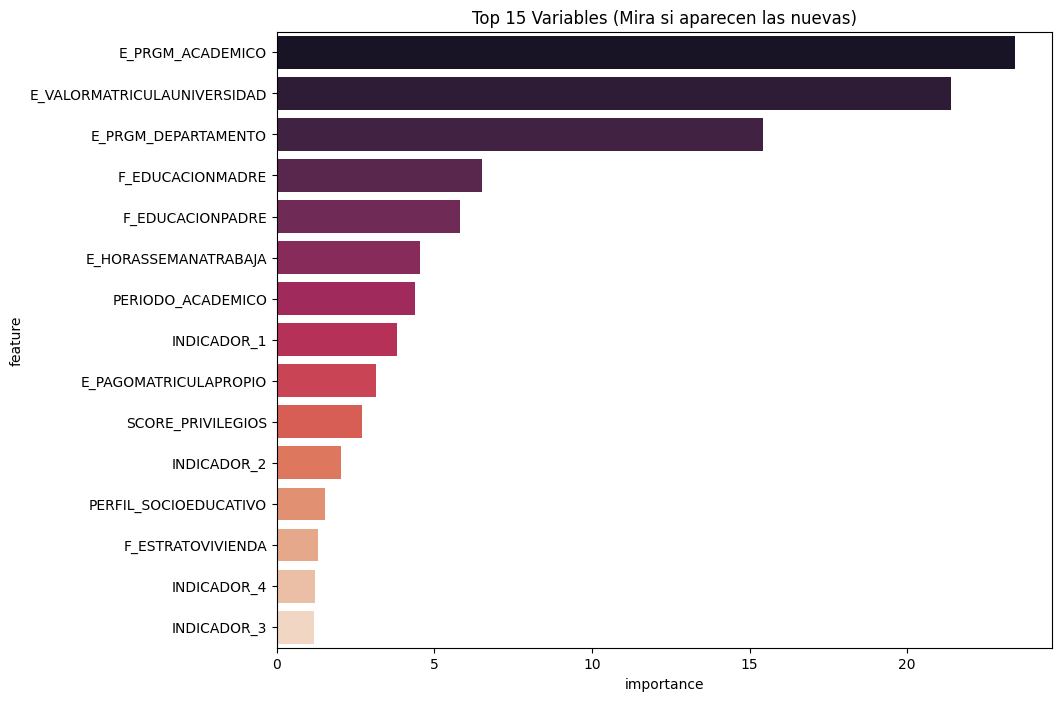

In [ ]:
fea_imp = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
fea_imp = fea_imp.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=fea_imp, palette='rocket')
plt.title('Top 15 Variables (Mira si aparecen las nuevas)')
plt.show()

#Generar Entrega

In [ ]:
# 1. Predecir (CatBoost devuelve un array de arrays, lo aplanamos)
print("🔮 Generando predicciones finales...")
predictions = model.predict(X_test_final).flatten()

# 2. Crear CSV
submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET_COL: predictions
})

# Nombre del archivo
out_filename = "submission_05_CatBoost_Optimized.csv"
submission.to_csv(out_filename, index=False)
print(f"💾 Archivo generado: {out_filename}")

# 3. Subir a Kaggle
message = "Notebook 05 - CatBoost GPU Optimized (Single Split)"
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f {out_filename} -m "{message}"

print("🚀 ¡Subida completada! Revisa el Leaderboard.")

🔮 Generando predicciones finales...
💾 Archivo generado: submission_05_CatBoost_Optimized.csv
100% 4.06M/4.06M [00:00<00:00, 5.63MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia🚀 ¡Subida completada! Revisa el Leaderboard.
